In [15]:
using Plots

include("distributions.jl")

include("distances/new_distance.jl")
include("distances/distance_Wasserstein.jl")


ww (generic function with 2 methods)

We want to get the effects of $n$ and $m$ for getting high true positive rate. In particular, If the choice is between high $n$ low $m$ or high $m$ low $n$, which one should we choose? 

For that we work on laws of RPM defined as
$$
\text{DP}(1.0, P_0) \quad \text{and} \quad \text{DP}(2.0, P_0),
$$

where $P_0 = \text{Uniform}(-1,1)$

# Rejection rate function

Firstly we need to have rejection rate function which receives as an argument laws of RPMS' and pair $(n, m)$, and outputes the rejection rate.

In [16]:
function sample_distances_thresholds(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int, θ::Float64, n_permutations::Int, 
    methods)
    # This functions samples distances between hierarchical empirical measures and also gets thresholds for each of the distance using permutatoin approach
    
    # Inputs:
        # q_1 :: Law of random probabiity measure Q^1
        # q_2 :: Law of random probabiity measure Q^2
        # n :: Number of rows in hierarchical sample
        # m :: Number of columns in hierarchical sample
        # s :: Number of distances sampled
        # θ :: Probability level for threshold
        # n_permutations :: Number of permutations for permutation approach
        # methods :: Vector of distance functions to be used. For example, [ww, dlip]
    
    n_methods = length(methods)
    distances = Array{Float64, 2}(undef, s, n_methods) # First dimension - generated empirical measure, second one - distance function


    perm_thresholds = zeros(s, n_methods) # First dimension - generated empirical measure, second one - distance function(WoW or HIPM)

    for i in 1:s
        println("s = $i")
        emp_1, emp_2 = generate_emp(q_1, n, m), generate_emp(q_2, n, m) # Q^1_{n,m}, Q^2_{n,m}
        for j in 1:n_methods
            distances[i, j] = methods[j](emp_1, emp_2) # sample distance between generated empirical measures using j-th distance function
        end
        
        # now we get threshold for each distance per each probability level θ. This is different from threshold via Rademacher complexity because here threshold
        # depends on the generated empirical measures.

        # To get threshold we first obtain approximate samples of d(Q^1_{n,m}, Q^2_{n,m}) that we call permuted_samples
        permuted_samples = zeros(n_permutations, n_methods) # First dimension - permutation sample, second one - distance function
        total_rows = vcat(emp_1.atoms, emp_2.atoms)

        for k in 1:n_permutations
            random_indices = randperm(2n) # indices to distribute rows to new hierarchical meausures

            emp_1_permuted = emp_ppm(total_rows[random_indices[1:n],:], n, m, emp_1.a, emp_1.b) # first n random rows go to first empirical measure
            emp_2_permuted = emp_ppm(total_rows[random_indices[n+1:end],:], n, m, emp_2.a, emp_2.b) # remaining n rows go to second empirical measure
 
            for j in 1:n_methods
                permuted_samples[k, j] = methods[j](emp_1_permuted, emp_2_permuted) # sample distance between permuted empirical measures using j-th distance function
            end
        end

        # Now we compute thresholds for each distance function at fixed significance/probability level θ. Actually they are not exactly same thresholds as in theory because we do not rescale by √(n/2). 
        # But this is ok because we only need to compare distances to thresholds and rescaling does not change the comparison.
        for j in 1:n_methods
            perm_thresholds[i, j] = quantile(permuted_samples[:, j], 1 - θ) # thresholds for each distance function
        end
    end
    
    return distances, perm_thresholds
end


function distances_vs_thresholds(distances::Array{Float64, 2}, perm_thresholds::Array{Float64, 2}, θ::Float64)
    # Given sampled distances and thresholds we compare them and get rejection rates for each distance function
    n = size(distances, 1) # number of sampled distances
    n_methods = size(distances, 2) # number of distance functions
    rej_rates = zeros(n_methods) # rejection rates for each distance function

    for j in 1:n_methods
        rej_rates[j] = sum(distances[:, j] .> perm_thresholds[:, j]) / n # how often does distance exceed the threshold
    end

    return rej_rates
end



distances_vs_thresholds (generic function with 1 method)

In [17]:
function rejection_rates(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int, θ::Float64, 
            n_permutations::Int, methods)
    # This function computes rejection rates for each distance function (WoW and HIPM) in list methods at fixed probability level θ

    # Inputs:
        # q_1 : Law of random probabiity measure Q^1
        # q_2 : Law of random probabiity measure Q^2
        # n : Number of rows in hierarchical sample
        # m : Number of columns in hierarchical sample
        # s : Number of distances sampled
        # θ : Probability level for threshold
        # n_permutations : Number of permutations for permutation approach
        # methods : Vector of distance functions to be used. For example, [ww, dlip]

    println("Computing rejection rates for n = $n, m = $m")
    # First we sample distances and thresholds
    distances, perm_thresholds = sample_distances_thresholds(q_1, q_2, n, m, s, θ, n_permutations, methods)

    # Now get the rejection rates by comparing distances to thresholds
    rej_rates = distances_vs_thresholds(distances, perm_thresholds, θ)

    return rej_rates
end

rejection_rates (generic function with 1 method)

# Convergence rates of power per n for fixed m's

Dirichlet processes as defined above will generate hierarchical samples with different distributions as long as $m$ is larger than $2.$ If we plot power functions per $n$ for different levels of $m$, we should expect these power functions to converge to $1$ faster for higher levels of $m$. But at the same time, this faster rates of convergence also should diminish.

In [18]:
# # define two laws of random probability measures
# α_1, α_2 = 1.0, 2.0
# P_0 = ()->probability("same") # uniform measure
# a,b = -1.0, 1.0
# q_1 = DP(α_1, P_0, a, b)
# q_2 = DP(α_2, P_0, a, b)

# S = 1
# n_permutations = 1 # number of permutations for permutation approach

# θ = 0.05
# methods = [ww, dlip] # list of distance functions to be used
# method_names = ["WoW", "HIPM"]

# power(n::Int, m::Int) = rejection_rates(q_1, q_2, n, m, S, θ, n_permutations, methods) # function to compute power for fixed n and m


In [19]:
dlip

dlip (generic function with 10 methods)

In [20]:
# ms = collect(2:10:22) # different m's
# ns = vcat(5, collect(10:10:70)) # different n's
# powers = [power(n_i, m_i) for n_i in ns, m_i in ms] # powers is a matrix where rows correspond to different n's and columns to different m's.
#                                                   # Each entry is a vector of length(menthods) where elements correspond to power for associated method

# plot_powers = [] # to store plots of per method
# for i in 1:length(methods)
#     plot_per_method = plot(title = "powers for $(method_names[i]) for fixed m's ", xlabel = "n", ylabel = "power", legend = :bottomright)# This 
#                             # will store plots of powers per n per each m for i-th method
#     for (j, m_j) in enumerate(ms)
#         powers_per_n = [powers[k, j][i] for k in 1:length(ns)]
#         plot!(plot_per_method, ns, powers_per_n, label = "m = $m_j", lw = 2, marker = :diamond)
#     end
#     push!(plot_powers, plot_per_method)
# end


# if length(methods) == 2
#     plot(plot_powers[1], plot_powers[2], layout = (2,1))
# else
#     plot_powers[1]
# end 

In [21]:
# plot_powers = plot(title = "powers for fixed m = $m", xlabel = "n", ylabel = "power", legend = :bottomright)
# plot!(plot_powers, n, powers_hipm, label = "HIPM", lw = 2, marker = :circle)
# plot!(plot_powers, n, powers_wow, label = "WoW", lw = 2, marker = :diamond)
# hline!([0.05], label = "significance level", ls = :dash, color = :black)
# display(plot_powers)

# Threshold at $m$ after which convergence of power function changes (from significance level to 1)


We know that if $m$ is not sufficiently large, hierarchical samples are generated from same probability measures. This will imply rejection rate to converge to chosen significance level as $n$ goes to $\infty.$ However, as long as $m$ is sufficiently large, hierarchical samples will have different probability distributions. This will imply that power function converge to $1.$ Let us fix large $n$ and vary $m$, to detect where jump in the convergence happens.


In [22]:
# define two laws of random probability measures
α_1, α_2 = 1.0, 2.0
P_0 = ()->probability("same") # uniform measure
a,b = -1.0, 1.0
q_1 = DP(α_1, P_0, a, b)
q_2 = DP(α_2, P_0, a, b)

S = 1
n_permutations = 1 # number of permutations for permutation approach

θ = 0.05
methods = [ww, dlip] # list of distance functions to be used
method_names = ["WoW", "HIPM"]

power(n::Int, m::Int) = rejection_rates(q_1, q_2, n, m, S, θ, n_permutations, methods) # function to compute power for fixed n and m


n = 100
ms = collect(1:1:10)


powers = [power(n, m_i) for m_i in ms]



# powers_hipm = [p[2] for p in powers]
# powers_wow = [p[1] for p in powers]
# plot_powers_m = plot(title = "powers for fixed n = $n", xlabel = "m", ylabel = "power", legend = :bottomright)
# plot!(plot_powers_m, m, powers_hipm, label = "HIPM", lw = 2, marker = :circle)
# plot!(plot_powers_m, m, powers_wow, label = "WoW", lw = 2, marker = :diamond)
# display(plot_powers_m)

Computing rejection rates for n = 100, m = 1
s = 1
Computing rejection rates for n = 100, m = 2
s = 1
Computing rejection rates for n = 100, m = 3
s = 1
Computing rejection rates for n = 100, m = 4
s = 1
Computing rejection rates for n = 100, m = 5
s = 1
Computing rejection rates for n = 100, m = 6
s = 1
Computing rejection rates for n = 100, m = 7
s = 1
Computing rejection rates for n = 100, m = 8
s = 1
Computing rejection rates for n = 100, m = 9
s = 1
Computing rejection rates for n = 100, m = 10
s = 1


10-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [0.0, 0.0]
 [1.0, 0.0]
 [1.0, 1.0]
 [1.0, 0.0]
 [1.0, 1.0]
 [0.0, 0.0]
 [1.0, 0.0]
 [1.0, 1.0]
 [1.0, 1.0]

# Fixed budget

Suppose that the budget is $1000$, i.e. $n + m = 1000.$ How should we choose $n, m$?

We can try $ n = d , m = 1000 = d $ for $d = 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$

In [23]:
# define two laws of random probability measures
α_1, α_2 = 1.0, 2.0
P_0 = ()->probability("same") # uniform measure
a,b = -1.0, 1.0
q_1 = DP(α_1, P_0, a, b)
q_2 = DP(α_2, P_0, a, b)
n, m = 5, 5 # number of rows and columns in hierarchical sample


S = 30
n_permutations = 30 # number of permutations for permutation approach

θ = 0.05

methods = [ww, dlip] # list of distance functions to be used
method_names = ["WoW", "HIPM"]

rej_rates(n, m) = rejection_rates(q_1, q_2, n, m, S, θ, n_permutations, methods)
#println("Rejection rates for WoW and HIPM are $(rej_rates(n, m))")

rej_rates (generic function with 1 method)

In [24]:
max_budget = 200
d = vcat([10],collect(25:50:max_budget))
powers = [rej_rates(d, max_budget - d) for d in d]

Computing rejection rates for n = 10, m = 190
s = 1
s = 2
s = 3
s = 4
s = 5
s = 6
s = 7
s = 8
s = 9
s = 10
s = 11
s = 12
s = 13
s = 14
s = 15
s = 16
s = 17
s = 18
s = 19
s = 20
s = 21
s = 22
s = 23
s = 24
s = 25
s = 26
s = 27
s = 28
s = 29
s = 30
Computing rejection rates for n = 25, m = 175
s = 1
s = 2
s = 3
s = 4
s = 5
s = 6
s = 7
s = 8
s = 9
s = 10
s = 11
s = 12
s = 13
s = 14
s = 15
s = 16
s = 17
s = 18
s = 19
s = 20
s = 21
s = 22
s = 23
s = 24
s = 25
s = 26
s = 27
s = 28
s = 29
s = 30
Computing rejection rates for n = 75, m = 125
s = 1
s = 2
s = 3
s = 4
s = 5
s = 6
s = 7
s = 8
s = 9
s = 10
s = 11
s = 12
s = 13
s = 14
s = 15
s = 16
s = 17
s = 18
s = 19
s = 20
s = 21
s = 22
s = 23
s = 24
s = 25
s = 26
s = 27
s = 28
s = 29
s = 30
Computing rejection rates for n = 125, m = 75
s = 1
s = 2
s = 3
s = 4
s = 5
s = 6
s = 7
s = 8
s = 9
s = 10
s = 11
s = 12
s = 13
s = 14
s = 15
s = 16
s = 17
s = 18
s = 19
s = 20
s = 21
s = 22
s = 23
s = 24
s = 25
s = 26
s = 27
s = 28
s = 29
s = 30
Computing re

5-element Vector{Vector{Float64}}:
 [0.06666666666666667, 0.06666666666666667]
 [0.13333333333333333, 0.13333333333333333]
 [0.5333333333333333, 0.23333333333333334]
 [0.7, 0.3]
 [0.7333333333333333, 0.3333333333333333]

In [25]:
# powers

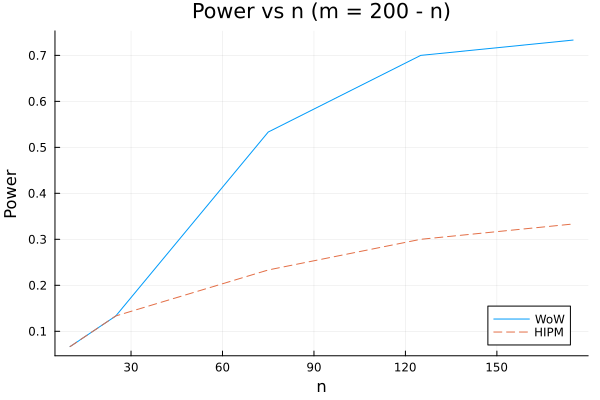

In [26]:
plot(d, getindex.(powers, 1), label="WoW", xlabel="n", ylabel="Power", title="Power vs n (m = $(max_budget) - n)", legend=:bottomright)
plot!(d, getindex.(powers, 2), label="HIPM", linestyle=:dash)


# Power grid per $n$ and $m$

In [27]:
# ns, ms = collect(10:10:100), collect(10:10:100)


# methods = [ww, dlip] # list of distance functions to be used
# method_names = ["WoW", "HIPM"]
# powers = [rej_rates(n_i, m_j) for n_i in ns, m_j in ms] # powers is a matrix where rows correspond to different n's and columns to different m's.
#                                                   # Each entry is a vector of length(menthods) where elements correspond to power for associated method

In [28]:
# methods = [ww, dlip] # list of distance functions to be used
# method_names = ["WoW", "HIPM"]